<a href="https://colab.research.google.com/github/costpetrides/FAIRMODE-WG5/blob/main/Python/IDW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IDW Method

In [50]:
pip install netCDF4

In [51]:
pip install cartopy

# IDW - Additive Method

In [ ]:
import os
import numpy as np
import pandas as pd
import netCDF4 as nc
from scipy.spatial import cKDTree
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import itertools

# === Φόρτωση δεδομένων από CSV ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Υπολογισμός bias
df["bias"] = df["SURF_ug_PM25_rh50"] - df["nearest_SURF_ug_PM25_rh50"]

# === Φόρτωση NetCDF ===
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

# Εξαγωγή δεδομένων πλέγματος
lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_modeled = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]

# Δημιουργία meshgrid
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
points_grid = np.column_stack([lon_mesh.ravel(), lat_mesh.ravel()])

# Προετοιμασία δεδομένων σταθμών
station_points = df[["nearest_grid_lon", "nearest_grid_lat"]].values
bias_values = df["bias"].values

# Κατασκευή KDTree για αποδοτική αναζήτηση γειτονικών σημείων
tree = cKDTree(station_points)

# === Εύρος τιμών για p και k ===
p_values =  np.arange(0.5, 5.1, 0.1).tolist()
k_values = np.arange(2, 41, 1).tolist()

# === Grid Search για τα καλύτερα p και k ===
kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = []
best_rmse = float("inf")
best_params = None

with tqdm(total=len(p_values) * len(k_values), desc="Grid Search with K-Fold") as pbar:
    for p, k in itertools.product(p_values, k_values):
        fold_rmses = []
        fold_maes = []
        fold_r2s = []

        for train_index, test_index in kf.split(station_points):
            train_points, test_points = station_points[train_index], station_points[test_index]
            train_values, test_values = bias_values[train_index], bias_values[test_index]

            train_tree = cKDTree(train_points)
            predicted_bias = []

            for test_point in test_points:
                dists, idxs = train_tree.query(test_point, k=k)

                if np.any(dists == 0):
                    predicted_bias.append(train_values[idxs[dists == 0]][0])
                else:
                    weights = 1 / (dists ** p)
                    interpolated_bias = np.sum(weights * train_values[idxs]) / np.sum(weights)
                    predicted_bias.append(interpolated_bias)

            fold_rmse = np.sqrt(mean_squared_error(test_values, predicted_bias))
            fold_mae = np.mean(np.abs(np.array(test_values) - np.array(predicted_bias)))
            fold_r2 = 1 - (np.sum((np.array(test_values) - np.array(predicted_bias)) ** 2) /
                           np.sum((np.array(test_values) - np.mean(test_values)) ** 2))

            fold_rmses.append(fold_rmse)
            fold_maes.append(fold_mae)
            fold_r2s.append(fold_r2)

        # Μέσοι όροι από όλα τα folds για αυτόν τον συνδυασμό p, k
        mean_rmse = np.mean(fold_rmses)
        mean_mae = np.mean(fold_maes)
        mean_r2 = np.mean(fold_r2s)

        results.append((p, k, mean_rmse, mean_mae, mean_r2))

        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = (p, k)

        pbar.update(1)

# Αποθήκευση αποτελεσμάτων grid search σε CSV
results_df = pd.DataFrame(results, columns=["p", "k", "RMSE", "MAE", "R2"])
results_df.to_csv("BaseCase_PM25_rh50_Y_IDW_add_Val.csv", index=False)

print(f"\nBest parameters found: p={best_params[0]}, k={best_params[1]} with Mean RMSE={best_rmse:.4f}")

# === Εφαρμογή IDW Additive με τα βέλτιστα p, k ===
def idw_additive(grid_points, station_points, values, p, k):
    grid_tree = cKDTree(grid_points)
    station_tree = cKDTree(station_points)

    # Query all grid points at once
    dists, idxs = station_tree.query(grid_points, k=k)

    # Handling zero distances
    zero_dist_mask = dists == 0
    interpolated = np.zeros(grid_points.shape[0])

    # Αν η απόσταση είναι μηδενική, χρησιμοποιούμε απευθείας την τιμή του σταθμού
    interpolated[zero_dist_mask[:, 0]] = values[idxs[zero_dist_mask[:, 0], 0]]

    # Για τα υπόλοιπα, υπολογίζουμε την IDW παρεμβολή
    non_zero_idx = ~zero_dist_mask[:, 0]

    dists_non_zero = dists[non_zero_idx]
    idxs_non_zero = idxs[non_zero_idx]

    weights = np.reciprocal(dists_non_zero ** p, where=dists_non_zero > 0)
    weights /= np.sum(weights, axis=1, keepdims=True)  # Κανονικοποίηση βαρών

    # Υπολογισμός παρεμβολής bias χωρίς scaling factor
    interpolated[non_zero_idx] = np.sum(weights * values[idxs_non_zero], axis=1)

    return interpolated

print("\nInterpolating bias using IDW Additive with optimized parameters...")
interpolated_bias_additive = idw_additive(points_grid, station_points, bias_values, best_params[0], best_params[1])
interpolated_bias_additive = interpolated_bias_additive.reshape(pm25_modeled.shape)

corrected_pm25_additive = pm25_modeled + interpolated_bias_additive

# === Αποθήκευση του διορθωμένου NetCDF ===
corrected_netcdf_path = "BaseCase_PM25_rh50_Y_IDW_add.nc"
if os.path.exists(corrected_netcdf_path):
    os.remove(corrected_netcdf_path)

new_dataset = nc.Dataset(corrected_netcdf_path, "w", format="NETCDF4")
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
pm25_var = new_dataset.createVariable("SURF_ug_PM25_rh50_corrected", "f4", ("lat", "lon"))

pm25_var.setncatts(dataset.variables["SURF_ug_PM25_rh50"].__dict__)
new_dataset.description = "Bias-corrected PM2.5 using IDW Additive with K-Fold (Optimized p & k, No Time Dimension)"

lat_var[:] = lat
lon_var[:] = lon
pm25_var[:, :] = corrected_pm25_additive

new_dataset.close()
dataset.close()

print("Bias correction using IDW Additive with K-Fold completed successfully! Corrected NetCDF file saved as", corrected_netcdf_path)


Grid Search with K-Fold: 100%|██████████| 1794/1794 [06:49<00:00,  4.38it/s]



Best parameters found: p=1.7999999999999998, k=34 with Mean RMSE=0.4908

Interpolating bias using IDW Additive with optimized parameters...
Bias correction using IDW Additive with K-Fold completed successfully! Corrected NetCDF file saved as BaseCase_PM25_rh50_Y_IDW_add.nc


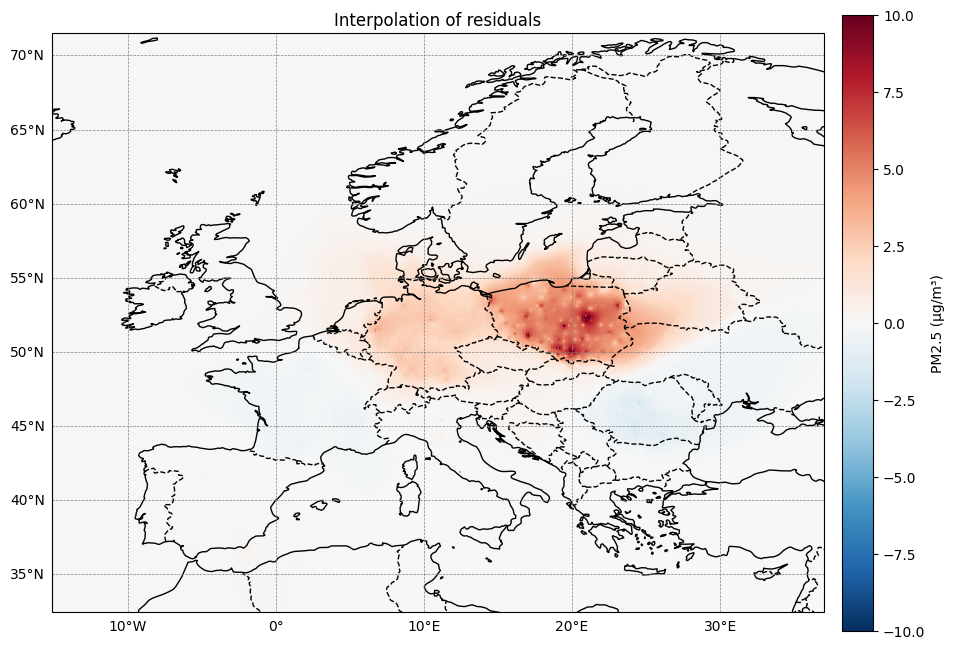

In [57]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Initial and Corrected NetCDF Files ===
initial_netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
corrected_netcdf_path = "Add/BaseCase_PM25_rh50_Y_IDW_add.nc"  # Change this if needed

# Open NetCDF datasets
ds_initial = xr.open_dataset(initial_netcdf_path)
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract PM2.5 data (Ensure no time dimension)
initial_pm25 = ds_initial["SURF_ug_PM25_rh50"].squeeze().values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Compute difference (Corrected - Initial) and ensure correct shape
difference = (corrected_pm25 - initial_pm25).squeeze()

# Extract coordinates
lon = ds_initial["lon"].values
lat = ds_initial["lat"].values

# === Define Plot Limits ===
cbar_min = -10
cbar_max = 10

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the difference (Ensure shape consistency)
im = ax.pcolormesh(lon, lat, difference, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("PM2.5 (µg/m³)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Interpolation of residuals")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close datasets
ds_initial.close()
ds_corrected.close()


In [ ]:
import os
import netCDF4 as nc
import numpy as np

# === Αρχεία εισόδου και εξόδου ===
original_nc_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
bias_nc_path = "BaseCase_PM25_rh50_Y_IDW_add.nc"
corrected_nc_path = "BaseCase_Corrected_PM25_rh50_Y_add.nc"

# Άνοιγμα των NetCDF αρχείων
with nc.Dataset(original_nc_path, "r") as original_nc, nc.Dataset(bias_nc_path, "r") as bias_nc:

    # Φόρτωση των δεδομένων
    lon = original_nc.variables["lon"][:]
    lat = original_nc.variables["lat"][:]
    time = original_nc.variables["time"][:]
    pm25_original = original_nc.variables["SURF_ug_PM25_rh50"][:]
    bias = bias_nc.variables["SURF_ug_PM25_rh50_corrected"][:]

    # Υπολογισμός διορθωμένων τιμών
    pm25_corrected = pm25_original + bias

    # === Δημιουργία νέου NetCDF ===
    if os.path.exists(corrected_nc_path):
        os.remove(corrected_nc_path)

    with nc.Dataset(corrected_nc_path, "w", format="NETCDF4") as new_nc:
        # Δημιουργία διαστάσεων
        new_nc.createDimension("time", None)
        new_nc.createDimension("lat", lat.shape[0])
        new_nc.createDimension("lon", lon.shape[0])

        # Δημιουργία μεταβλητών
        time_var = new_nc.createVariable("time", "f4", ("time",))
        lat_var = new_nc.createVariable("lat", "f4", ("lat",))
        lon_var = new_nc.createVariable("lon", "f4", ("lon",))
        pm25_var = new_nc.createVariable("SURF_ug_PM25_rh50_corrected", "f4", ("time", "lat", "lon"), fill_value=-9999.0)

        # Αντιγραφή attributes από το αρχικό αρχείο
        pm25_var.setncatts(original_nc.variables["SURF_ug_PM25_rh50"].__dict__)

        # Αντιγραφή δεδομένων
        time_var[:] = time
        lat_var[:] = lat
        lon_var[:] = lon
        pm25_var[:] = pm25_corrected

print("Bias correction completed successfully! Corrected NetCDF file saved as", corrected_nc_path)


Bias correction completed successfully! Corrected NetCDF file saved as BaseCase_Corrected_PM25_rh50_Y_add.nc


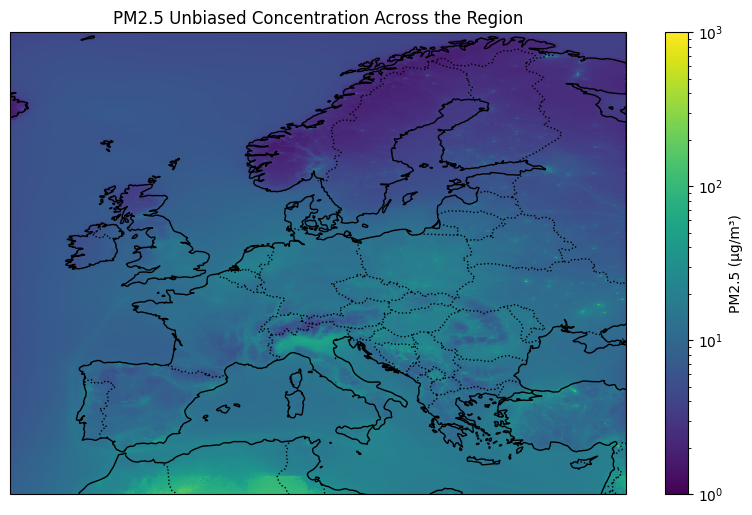

In [62]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

# Open the NetCDF file for PM25
PM25map = netCDF4.Dataset('Add/BaseCase_Corrected_PM25_rh50_Y_add.nc', 'r')  # Replace with the actual file name

# Extract variables: lon, lat, and PM2.5 concentration (first time point)
lon = PM25map.variables['lon'][:]
lat = PM25map.variables['lat'][:]
PM25 = PM25map.variables['SURF_ug_PM25_rh50_corrected'][0, :, :]  # Only the first time point

# Close the dataset
PM25map.close()

# Mask out invalid data (_FillValue)
fill_value = 9.969209968386869e+36  # _FillValue for invalid entries
PM25 = np.ma.masked_equal(PM25, fill_value)


# Define a logarithmic norm
norm = mcolors.LogNorm(vmin=1, vmax=1000)  # Apply logarithmic normalization from 1 to 10000

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the PM2.5 concentration using pcolormesh with logarithmic scaling
mesh = ax.pcolormesh(lon, lat, PM25, cmap='viridis', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# Add a colorbar with the new scale
plt.colorbar(mesh, label='PM2.5 (µg/m³)')

# Add coastlines and borders for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Title and labels
plt.title('PM2.5 Unbiased Concentration Across the Region')

# Show the plot
plt.show()

# IDW - Rescaled Additive Method

In [58]:
import os
import numpy as np
import pandas as pd
import netCDF4 as nc
from scipy.spatial import cKDTree
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import itertools

# === Φόρτωση δεδομένων από CSV ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Υπολογισμός bias
df["bias"] = df["SURF_ug_PM25_rh50"] - df["nearest_SURF_ug_PM25_rh50"]

# === Φόρτωση NetCDF ===
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

# Εξαγωγή δεδομένων πλέγματος
lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_modeled = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]

# Δημιουργία meshgrid
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
points_grid = np.column_stack([lon_mesh.ravel(), lat_mesh.ravel()])

# Προετοιμασία δεδομένων σταθμών
station_points = df[["nearest_grid_lon", "nearest_grid_lat"]].values
bias_values = df["bias"].values

# Κατασκευή KDTree για αποδοτική αναζήτηση γειτονικών σημείων
tree = cKDTree(station_points)

# === Εύρος τιμών για p και k ===
p_values =  np.arange(1, 10.1, 0.1).tolist()
k_values = np.arange(5, 200, 5).tolist()

# === Grid Search για τα καλύτερα p και k ===
kf = KFold(n_splits=10, shuffle=True, random_state=42)  # Χρησιμοποιούμε 10-Fold Cross Validation
results = []
best_rmse = float("inf")
best_params = None

with tqdm(total=len(p_values) * len(k_values), desc="Grid Search with K-Fold") as pbar:
    for p, k in itertools.product(p_values, k_values):
        fold_rmses = []
        fold_maes = []
        fold_r2s = []

        for train_index, test_index in kf.split(station_points):
            train_points, test_points = station_points[train_index], station_points[test_index]
            train_values, test_values = bias_values[train_index], bias_values[test_index]

            train_tree = cKDTree(train_points)
            predicted_bias = []

            for test_point in test_points:
                dists, idxs = train_tree.query(test_point, k=k)

                if np.any(dists == 0):
                    predicted_bias.append(train_values[idxs[dists == 0]][0])
                else:
                    weights = 1 / (dists ** p)
                    interpolated_bias = np.sum(weights * train_values[idxs]) / np.sum(weights)
                    predicted_bias.append(interpolated_bias)

            fold_rmse = np.sqrt(mean_squared_error(test_values, predicted_bias))
            fold_mae = np.mean(np.abs(np.array(test_values) - np.array(predicted_bias)))
            fold_r2 = 1 - (np.sum((np.array(test_values) - np.array(predicted_bias)) ** 2) /
                           np.sum((np.array(test_values) - np.mean(test_values)) ** 2))

            fold_rmses.append(fold_rmse)
            fold_maes.append(fold_mae)
            fold_r2s.append(fold_r2)

        # Μέσοι όροι από όλα τα folds για αυτόν τον συνδυασμό p, k
        mean_rmse = np.mean(fold_rmses)
        mean_mae = np.mean(fold_maes)
        mean_r2 = np.mean(fold_r2s)

        results.append((p, k, mean_rmse, mean_mae, mean_r2))

        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = (p, k)

        pbar.update(1)

# Αποθήκευση αποτελεσμάτων grid search σε CSV
results_df = pd.DataFrame(results, columns=["p", "k", "RMSE", "MAE", "R2"])
results_df.to_csv("BaseCase_PM25_rh50_Y_IDW_resc_Val.csv", index=False)

print(f"\nBest parameters found: p={best_params[0]}, k={best_params[1]} with Mean RMSE={best_rmse:.4f}")

# === Εφαρμογή IDW Rescaled Additive με τα βέλτιστα p, k ===
def idw_rescaled_additive(grid_points, station_points, values, pm25_modeled, p, k):
    interpolated = np.zeros(grid_points.shape[0])

    grid_tree = cKDTree(points_grid)

    for i in tqdm(range(grid_points.shape[0]), desc="Interpolating IDW Rescaled Additive", unit="grid point"):
        dists, idxs = tree.query(grid_points[i], k=k)

        if np.any(dists == 0):
            interpolated[i] = values[idxs[dists == 0]][0]
            continue

        weights = np.reciprocal(dists**p, where=dists > 0)
        _, grid_idx = grid_tree.query(station_points[idxs])
        pm25_grid_values = pm25_modeled.ravel()[grid_idx]

        scaling_factor = np.sum(weights * pm25_grid_values) / np.sum(weights)
        interpolated[i] = scaling_factor * np.dot(weights, values[idxs]) / np.sum(weights)

    return interpolated

print("\nInterpolating bias using IDW Rescaled Additive with optimized parameters...")
interpolated_bias_rescaled = idw_rescaled_additive(points_grid, station_points, bias_values, pm25_modeled, best_params[0], best_params[1])
interpolated_bias_rescaled = interpolated_bias_rescaled.reshape(pm25_modeled.shape)

corrected_pm25_rescaled = pm25_modeled + interpolated_bias_rescaled

# === Αποθήκευση του διορθωμένου NetCDF ===
corrected_netcdf_path = "BaseCase_PM25_rh50_Y_IDW_resc.nc"
if os.path.exists(corrected_netcdf_path):
    os.remove(corrected_netcdf_path)

new_dataset = nc.Dataset(corrected_netcdf_path, "w", format="NETCDF4")
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
pm25_var = new_dataset.createVariable("SURF_ug_PM25_rh50_corrected", "f4", ("lat", "lon"))

pm25_var.setncatts(dataset.variables["SURF_ug_PM25_rh50"].__dict__)
new_dataset.description = "Bias-corrected PM2.5 using IDW Rescaled Additive with K-Fold (Optimized p & k, No Time Dimension)"

lat_var[:] = lat
lon_var[:] = lon
pm25_var[:, :] = corrected_pm25_rescaled

new_dataset.close()
dataset.close()

print("Bias correction using IDW Rescaled Additive with K-Fold completed successfully! Corrected NetCDF file saved as", corrected_netcdf_path)


Grid Search with K-Fold: 100%|██████████| 624/624 [02:58<00:00,  3.50it/s]



Best parameters found: p=2.5, k=175 with Mean RMSE=0.4974

Interpolating bias using IDW Rescaled Additive with optimized parameters...


Interpolating IDW Rescaled Additive: 100%|██████████| 406901/406901 [03:29<00:00, 1944.79grid point/s]

Bias correction using IDW Rescaled Additive with K-Fold completed successfully! Corrected NetCDF file saved as BaseCase_PM25_rh50_Y_IDW_resc.nc


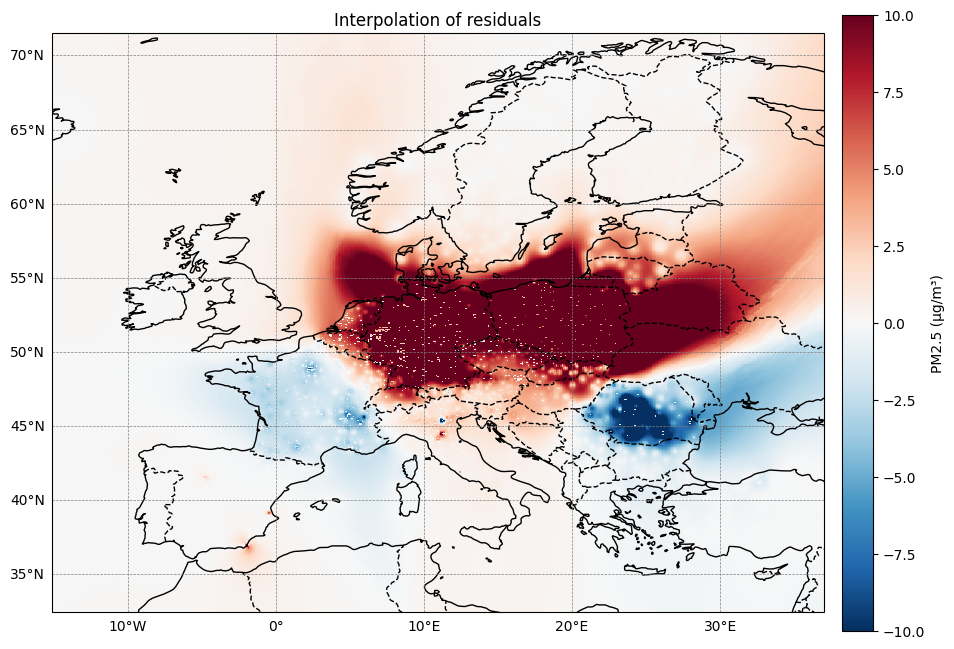

In [87]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Initial and Corrected NetCDF Files ===
initial_netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
corrected_netcdf_path = "Resc/BaseCase_PM25_rh50_Y_IDW_resc.nc"  # Change this if needed

# Open NetCDF datasets
ds_initial = xr.open_dataset(initial_netcdf_path)
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract PM2.5 data (Ensure no time dimension)
initial_pm25 = ds_initial["SURF_ug_PM25_rh50"].squeeze().values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Compute difference (Corrected - Initial) and ensure correct shape
difference = (corrected_pm25 - initial_pm25).squeeze()

# Extract coordinates
lon = ds_initial["lon"].values
lat = ds_initial["lat"].values

# === Define Plot Limits ===
cbar_min = -10
cbar_max = 10

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the difference (Ensure shape consistency)
im = ax.pcolormesh(lon, lat, difference, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("PM2.5 (µg/m³)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Interpolation of residuals")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close datasets
ds_initial.close()
ds_corrected.close()


In [66]:
import os
import netCDF4 as nc
import numpy as np

# === Αρχεία εισόδου και εξόδου ===
original_nc_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
bias_nc_path = "Resc/BaseCase_PM25_rh50_Y_IDW_resc.nc"
corrected_nc_path = "Resc/BaseCase_Corrected_PM25_rh50_Y_resc.nc"

# Άνοιγμα των NetCDF αρχείων
with nc.Dataset(original_nc_path, "r") as original_nc, nc.Dataset(bias_nc_path, "r") as bias_nc:

    # Φόρτωση των δεδομένων
    lon = original_nc.variables["lon"][:]
    lat = original_nc.variables["lat"][:]
    time = original_nc.variables["time"][:]
    pm25_original = original_nc.variables["SURF_ug_PM25_rh50"][:]
    bias = bias_nc.variables["SURF_ug_PM25_rh50_corrected"][:]

    # Υπολογισμός διορθωμένων τιμών
    pm25_corrected = pm25_original + bias

    # === Δημιουργία νέου NetCDF ===
    if os.path.exists(corrected_nc_path):
        os.remove(corrected_nc_path)

    with nc.Dataset(corrected_nc_path, "w", format="NETCDF4") as new_nc:
        # Δημιουργία διαστάσεων
        new_nc.createDimension("time", None)
        new_nc.createDimension("lat", lat.shape[0])
        new_nc.createDimension("lon", lon.shape[0])

        # Δημιουργία μεταβλητών
        time_var = new_nc.createVariable("time", "f4", ("time",))
        lat_var = new_nc.createVariable("lat", "f4", ("lat",))
        lon_var = new_nc.createVariable("lon", "f4", ("lon",))
        pm25_var = new_nc.createVariable("SURF_ug_PM25_rh50_corrected", "f4", ("time", "lat", "lon"), fill_value=-9999.0)

        # Αντιγραφή attributes από το αρχικό αρχείο
        pm25_var.setncatts(original_nc.variables["SURF_ug_PM25_rh50"].__dict__)

        # Αντιγραφή δεδομένων
        time_var[:] = time
        lat_var[:] = lat
        lon_var[:] = lon
        pm25_var[:] = pm25_corrected

print("Bias correction completed successfully! Corrected NetCDF file saved as", corrected_nc_path)


Bias correction completed successfully! Corrected NetCDF file saved as Resc/BaseCase_Corrected_PM25_rh50_Y_resc.nc


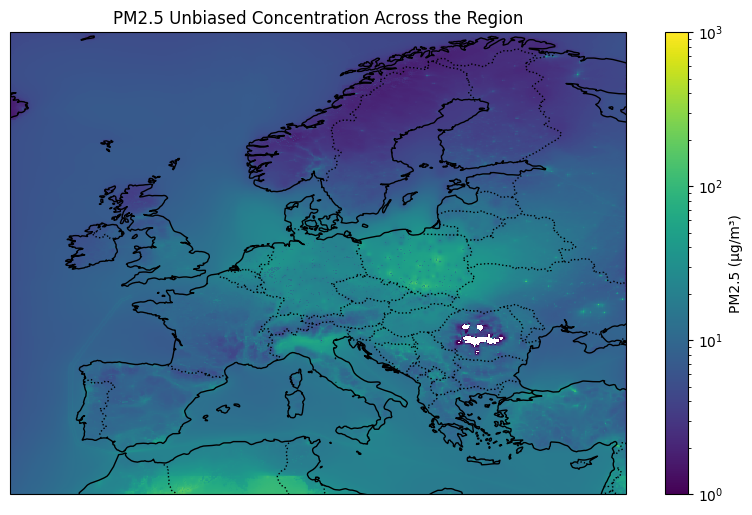

In [67]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

# Open the NetCDF file for PM25
PM25map = netCDF4.Dataset('Resc/BaseCase_Corrected_PM25_rh50_Y_resc.nc', 'r')  # Replace with the actual file name

# Extract variables: lon, lat, and PM2.5 concentration (first time point)
lon = PM25map.variables['lon'][:]
lat = PM25map.variables['lat'][:]
PM25 = PM25map.variables['SURF_ug_PM25_rh50_corrected'][0, :, :]  # Only the first time point

# Close the dataset
PM25map.close()

# Mask out invalid data (_FillValue)
fill_value = 9.969209968386869e+36  # _FillValue for invalid entries
PM25 = np.ma.masked_equal(PM25, fill_value)


# Define a logarithmic norm
norm = mcolors.LogNorm(vmin=1, vmax=1000)  # Apply logarithmic normalization from 1 to 10000

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the PM2.5 concentration using pcolormesh with logarithmic scaling
mesh = ax.pcolormesh(lon, lat, PM25, cmap='viridis', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# Add a colorbar with the new scale
plt.colorbar(mesh, label='PM2.5 (µg/m³)')

# Add coastlines and borders for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Title and labels
plt.title('PM2.5 Unbiased Concentration Across the Region')

# Show the plot
plt.show()

# IDW- Multiplicative Mehod

In [68]:
import os
import numpy as np
import pandas as pd
import netCDF4 as nc
from scipy.spatial import cKDTree
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
import itertools

# === Load Data ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Compute bias ratio (Multiplicative factor: Observed / Modeled)
df["bias_ratio"] = df["SURF_ug_PM25_rh50"] / df["nearest_SURF_ug_PM25_rh50"]
df["bias_ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)  # Remove infinities
df.dropna(subset=["bias_ratio"], inplace=True)  # Drop NaN values

# Load NetCDF file
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

# Extract grid coordinates
lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_modeled = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]  # Remove time dimension

# Create meshgrid
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
points_grid = np.column_stack([lon_mesh.ravel(), lat_mesh.ravel()])

# Prepare station data points
station_points = df[["nearest_grid_lon", "nearest_grid_lat"]].values
bias_ratios = df["bias_ratio"].values

# === Grid Search για τα καλύτερα p και k ===
kf = KFold(n_splits=10, shuffle=True, random_state=42)  # Χρησιμοποιούμε 10-Fold Cross Validation
results = []
best_rmse = float("inf")
best_params = None

p_values =  np.arange(0.5, 32, 2).tolist()
k_values = np.arange(5, 200, 5).tolist()

with tqdm(total=len(p_values) * len(k_values), desc="Grid Search with K-Fold") as pbar:
    for p, k in itertools.product(p_values, k_values):
        fold_rmses, fold_maes, fold_r2s = [], [], []

        for train_index, test_index in kf.split(station_points):
            train_points, test_points = station_points[train_index], station_points[test_index]
            train_values, test_values = bias_ratios[train_index], bias_ratios[test_index]

            train_tree = cKDTree(train_points)
            predicted_bias_ratio = []

            for test_point in test_points:
                dists, idxs = train_tree.query(test_point, k=k)

                if np.any(dists == 0):
                    predicted_bias_ratio.append(train_values[idxs[dists == 0]][0])
                else:
                    weights = 1 / (dists ** p)
                    interpolated_bias = np.sum(weights * train_values[idxs]) / np.sum(weights)
                    predicted_bias_ratio.append(interpolated_bias)

            # Υπολογισμός στατιστικών
            fold_rmse = np.sqrt(mean_squared_error(test_values, predicted_bias_ratio))
            fold_mae = mean_absolute_error(test_values, predicted_bias_ratio)
            fold_r2 = r2_score(test_values, predicted_bias_ratio)

            fold_rmses.append(fold_rmse)
            fold_maes.append(fold_mae)
            fold_r2s.append(fold_r2)

        # Μέσος όρος των στατιστικών από όλα τα folds
        mean_rmse = np.mean(fold_rmses)
        mean_mae = np.mean(fold_maes)
        mean_r2 = np.mean(fold_r2s)

        results.append((p, k, mean_rmse, mean_mae, mean_r2))

        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = (p, k)

        pbar.update(1)

# Αποθήκευση αποτελεσμάτων σε CSV
results_df = pd.DataFrame(results, columns=["p", "k", "Mean RMSE", "Mean MAE", "Mean R2"])
results_df.to_csv("BaseCase_PM25_Y_IDW_mul.Val.csv", index=False)

print(f"\nBest parameters found: p={best_params[0]}, k={best_params[1]} with Mean RMSE={best_rmse:.4f}")

# === IDW Multiplicative με τα βέλτιστα p, k ===
def idw_multiplicative(grid_points, station_points, values, p, k):
    interpolated = np.zeros(grid_points.shape[0])

    for i in tqdm(range(grid_points.shape[0]), desc="Interpolating IDW Multiplicative", unit="grid point"):
        dists, idxs = tree.query(grid_points[i], k=k)

        if np.any(dists == 0):
            interpolated[i] = values[idxs[dists == 0]][0]
        else:
            weights = np.reciprocal(dists**p, where=dists > 0)
            interpolated[i] = np.dot(weights, values[idxs]) / np.sum(weights)

    return interpolated

print("\nInterpolating bias ratio using IDW Multiplicative with optimized parameters...")
interpolated_bias_ratio = idw_multiplicative(points_grid, station_points, bias_ratios, best_params[0], best_params[1])
interpolated_bias_ratio = interpolated_bias_ratio.reshape(pm25_modeled.shape)

corrected_pm25_mul = pm25_modeled * interpolated_bias_ratio

# === Αποθήκευση του Διορθωμένου NetCDF ===
corrected_netcdf_path = "BaseCase_PM25_rh50_Y_IDW_mul.nc"

if os.path.exists(corrected_netcdf_path):
    os.remove(corrected_netcdf_path)
    print(f"Deleted existing file: {corrected_netcdf_path}")

new_dataset = nc.Dataset(corrected_netcdf_path, "w", format="NETCDF4")

# Δημιουργία διαστάσεων
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])

# Δημιουργία μεταβλητών
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
pm25_var = new_dataset.createVariable("SURF_ug_PM25_rh50_corrected", "f4", ("lat", "lon"))

# Αντιγραφή metadata
pm25_var.setncatts(dataset.variables["SURF_ug_PM25_rh50"].__dict__)
new_dataset.description = "Bias-corrected PM2.5 using IDW Multiplicative (Optimized p & k, No Time Dimension)"

# Αντιγραφή δεδομένων
lat_var[:] = lat
lon_var[:] = lon
pm25_var[:, :] = corrected_pm25_mul

# Κλείσιμο αρχείων
new_dataset.close()
dataset.close()

print("Bias correction using IDW Multiplicative (Optimized p & k) completed successfully! Corrected NetCDF file saved as", corrected_netcdf_path)


<ipython-input-68-c6864734aa11>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["bias_ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)  # Remove infinities
Grid Search with K-Fold: 100%|██████████| 624/624 [03:03<00:00,  3.40it/s]



Best parameters found: p=2.5, k=40 with Mean RMSE=0.0533

Interpolating bias ratio using IDW Multiplicative with optimized parameters...


Interpolating IDW Multiplicative: 100%|██████████| 406901/406901 [00:36<00:00, 11118.94grid point/s]

Bias correction using IDW Multiplicative (Optimized p & k) completed successfully! Corrected NetCDF file saved as BaseCase_PM25_rh50_Y_IDW_mul.nc


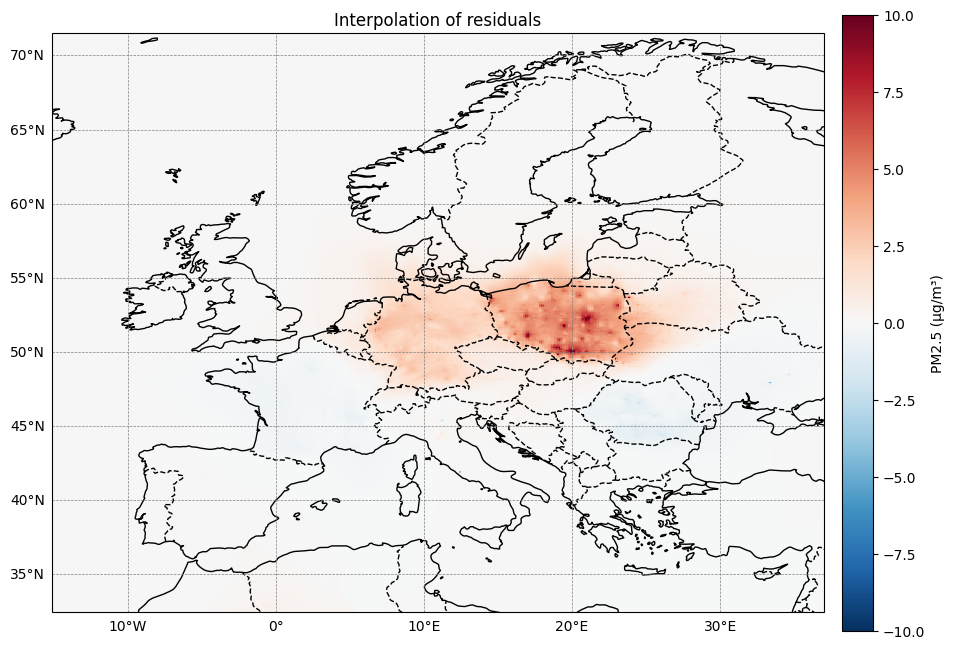

In [88]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Initial and Corrected NetCDF Files ===
initial_netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
corrected_netcdf_path = "Mult/BaseCase_PM25_rh50_Y_IDW_mul.nc"  # Change this if needed

# Open NetCDF datasets
ds_initial = xr.open_dataset(initial_netcdf_path)
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract PM2.5 data (Ensure no time dimension)
initial_pm25 = ds_initial["SURF_ug_PM25_rh50"].squeeze().values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Compute difference (Corrected - Initial) and ensure correct shape
difference = (corrected_pm25 - initial_pm25).squeeze()

# Extract coordinates
lon = ds_initial["lon"].values
lat = ds_initial["lat"].values

# === Define Plot Limits ===
cbar_min = -10
cbar_max = 10

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the difference (Ensure shape consistency)
im = ax.pcolormesh(lon, lat, difference, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("PM2.5 (µg/m³)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Interpolation of residuals")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close datasets
ds_initial.close()
ds_corrected.close()


In [72]:
import os
import netCDF4 as nc
import numpy as np

# === Αρχεία εισόδου και εξόδου ===
original_nc_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
bias_nc_path = "Mult/BaseCase_PM25_rh50_Y_IDW_mul.nc"
corrected_nc_path = "Mult/BaseCase_Corrected_PM25_rh50_Y_mul.nc"

# Άνοιγμα των NetCDF αρχείων
with nc.Dataset(original_nc_path, "r") as original_nc, nc.Dataset(bias_nc_path, "r") as bias_nc:

    # Φόρτωση των δεδομένων
    lon = original_nc.variables["lon"][:]
    lat = original_nc.variables["lat"][:]
    time = original_nc.variables["time"][:]
    pm25_original = original_nc.variables["SURF_ug_PM25_rh50"][:]
    bias = bias_nc.variables["SURF_ug_PM25_rh50_corrected"][:]

    # Υπολογισμός διορθωμένων τιμών
    pm25_corrected = pm25_original + bias

    # === Δημιουργία νέου NetCDF ===
    if os.path.exists(corrected_nc_path):
        os.remove(corrected_nc_path)

    with nc.Dataset(corrected_nc_path, "w", format="NETCDF4") as new_nc:
        # Δημιουργία διαστάσεων
        new_nc.createDimension("time", None)
        new_nc.createDimension("lat", lat.shape[0])
        new_nc.createDimension("lon", lon.shape[0])

        # Δημιουργία μεταβλητών
        time_var = new_nc.createVariable("time", "f4", ("time",))
        lat_var = new_nc.createVariable("lat", "f4", ("lat",))
        lon_var = new_nc.createVariable("lon", "f4", ("lon",))
        pm25_var = new_nc.createVariable("SURF_ug_PM25_rh50_corrected", "f4", ("time", "lat", "lon"), fill_value=-9999.0)

        # Αντιγραφή attributes από το αρχικό αρχείο
        pm25_var.setncatts(original_nc.variables["SURF_ug_PM25_rh50"].__dict__)

        # Αντιγραφή δεδομένων
        time_var[:] = time
        lat_var[:] = lat
        lon_var[:] = lon
        pm25_var[:] = pm25_corrected

print("Bias correction completed successfully! Corrected NetCDF file saved as", corrected_nc_path)


Bias correction completed successfully! Corrected NetCDF file saved as Mult/BaseCase_Corrected_PM25_rh50_Y_mul.nc


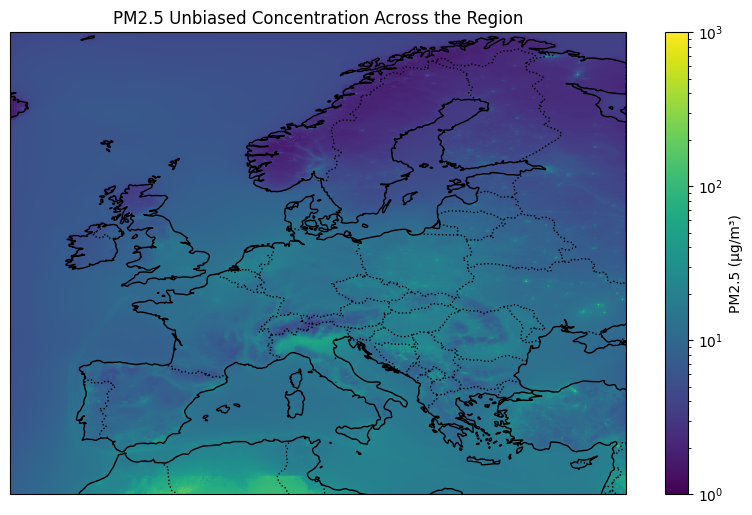

In [73]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

# Open the NetCDF file for PM25
PM25map = netCDF4.Dataset('Mult/BaseCase_Corrected_PM25_rh50_Y_mul.nc', 'r')  # Replace with the actual file name

# Extract variables: lon, lat, and PM2.5 concentration (first time point)
lon = PM25map.variables['lon'][:]
lat = PM25map.variables['lat'][:]
PM25 = PM25map.variables['SURF_ug_PM25_rh50_corrected'][0, :, :]  # Only the first time point

# Close the dataset
PM25map.close()

# Mask out invalid data (_FillValue)
fill_value = 9.969209968386869e+36  # _FillValue for invalid entries
PM25 = np.ma.masked_equal(PM25, fill_value)


# Define a logarithmic norm
norm = mcolors.LogNorm(vmin=1, vmax=1000)  # Apply logarithmic normalization from 1 to 10000

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the PM2.5 concentration using pcolormesh with logarithmic scaling
mesh = ax.pcolormesh(lon, lat, PM25, cmap='viridis', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# Add a colorbar with the new scale
plt.colorbar(mesh, label='PM2.5 (µg/m³)')

# Add coastlines and borders for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Title and labels
plt.title('PM2.5 Unbiased Concentration Across the Region')

# Show the plot
plt.show()

# IDW - Hybrid Correction (Additive & Multiplicative)

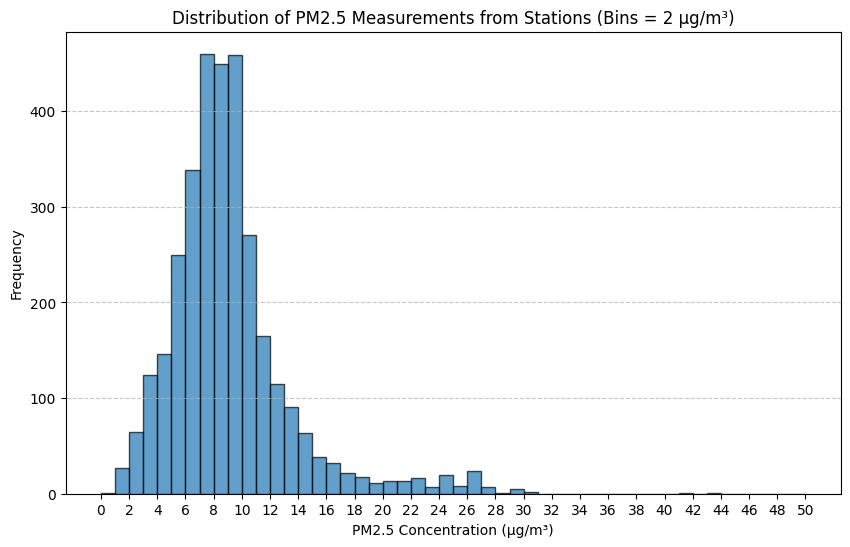

In [74]:
import matplotlib.pyplot as plt

# Φόρτωση των δεδομένων
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Επιλογή της στήλης με τις τιμές PM2.5 από τους σταθμούς
pm25_values = df["SURF_ug_PM25_rh50"].dropna()  # Αφαίρεση NaN

# Δημιουργία ιστογράμματος με εύρος από 0 έως 50 και bins=2
plt.figure(figsize=(10,6))
plt.hist(pm25_values, bins=np.arange(0, 51, 1), edgecolor="black", alpha=0.7)

# Προσθήκη ετικετών
plt.xlabel("PM2.5 Concentration (µg/m³)")
plt.ylabel("Frequency")
plt.title("Distribution of PM2.5 Measurements from Stations (Bins = 2 µg/m³)")
plt.xticks(np.arange(0, 52, 2))
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Προβολή του γραφήματος
plt.show()

In [75]:
import os
import numpy as np
import pandas as pd
import netCDF4 as nc
from scipy.spatial import cKDTree
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
import itertools

# === Load Data ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Compute Additive Bias
df["bias_additive"] = df["SURF_ug_PM25_rh50"] - df["nearest_SURF_ug_PM25_rh50"]

# Compute Multiplicative Bias Ratio
df["bias_ratio"] = df["SURF_ug_PM25_rh50"] / df["nearest_SURF_ug_PM25_rh50"]
df["bias_ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=["bias_ratio"], inplace=True)

# Load NetCDF file
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

# Extract NetCDF grid coordinates
lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_modeled = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]

# Create meshgrid
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
points_grid = np.column_stack([lon_mesh.ravel(), lat_mesh.ravel()])

# Prepare station data points
station_points = df[["nearest_grid_lon", "nearest_grid_lat"]].values
bias_additive_values = df["bias_additive"].values
bias_ratio_values = df["bias_ratio"].values

# Build KDTree for efficient nearest neighbor search
tree = cKDTree(station_points)

# === Grid Search for the best p and k ===
kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = []
best_rmse = float("inf")
best_params = None

# Hyperparameter candidates
p_values = np.arange(0.5, 32, 2).tolist()
k_values = np.arange(5, 200, 5).tolist()
threshold = 5

with tqdm(total=len(p_values) * len(k_values), desc="Grid Search with K-Fold") as pbar:
    for p, k in itertools.product(p_values, k_values):
        fold_rmses, fold_maes, fold_r2s = [], [], []

        for train_index, test_index in kf.split(station_points):
            train_points, test_points = station_points[train_index], station_points[test_index]
            train_additive_values = bias_additive_values[train_index]
            train_ratio_values = bias_ratio_values[train_index]

            test_additive_values = bias_additive_values[test_index]
            test_ratio_values = bias_ratio_values[test_index]

            train_tree = cKDTree(train_points)

            predicted_additive = []
            predicted_ratio = []

            for test_point in test_points:
                dists, idxs = train_tree.query(test_point, k=k)

                if np.any(dists == 0):
                    predicted_additive.append(train_additive_values[idxs[dists == 0]][0])
                    predicted_ratio.append(train_ratio_values[idxs[dists == 0]][0])
                else:
                    weights = 1 / (dists ** p)
                    interpolated_additive = np.sum(weights * train_additive_values[idxs]) / np.sum(weights)
                    interpolated_ratio = np.sum(weights * train_ratio_values[idxs]) / np.sum(weights)

                    predicted_additive.append(interpolated_additive)
                    predicted_ratio.append(interpolated_ratio)

            # Compute metrics
            fold_rmse_additive = np.sqrt(mean_squared_error(test_additive_values, predicted_additive))
            fold_rmse_ratio = np.sqrt(mean_squared_error(test_ratio_values, predicted_ratio))
            fold_rmse = (fold_rmse_additive + fold_rmse_ratio) / 2

            fold_mae_additive = mean_absolute_error(test_additive_values, predicted_additive)
            fold_mae_ratio = mean_absolute_error(test_ratio_values, predicted_ratio)
            fold_mae = (fold_mae_additive + fold_mae_ratio) / 2

            fold_r2_additive = r2_score(test_additive_values, predicted_additive)
            fold_r2_ratio = r2_score(test_ratio_values, predicted_ratio)
            fold_r2 = (fold_r2_additive + fold_r2_ratio) / 2

            fold_rmses.append(fold_rmse)
            fold_maes.append(fold_mae)
            fold_r2s.append(fold_r2)

        # Compute average metrics across all folds
        mean_rmse = np.mean(fold_rmses)
        mean_mae = np.mean(fold_maes)
        mean_r2 = np.mean(fold_r2s)

        results.append((p, k, mean_rmse, mean_mae, mean_r2))

        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = (p, k)

        pbar.update(1)

# Save results to CSV
results_df = pd.DataFrame(results, columns=["p", "k", "Mean RMSE", "Mean MAE", "Mean R2"])
results_df.to_csv("BaseCase_PM25_rh50_Y_IDW_ΗAM_Val.csv", index=False)

print(f"\nBest parameters found: p={best_params[0]}, k={best_params[1]} with Mean RMSE={best_rmse:.4f}")

# === Hybrid IDW Function ===
def idw_hybrid(grid_points, station_points, bias_additive, bias_ratio, pm25_modeled, p, k, threshold):
    interpolated = np.zeros(grid_points.shape[0])

    for i in tqdm(range(grid_points.shape[0]), desc="Interpolating Hybrid IDW", unit="grid point"):
        dists, idxs = tree.query(grid_points[i], k=k)

        if np.any(dists == 0):  # Exact match case
            interpolated[i] = bias_additive[idxs[dists == 0]][0]
        else:
            weights = 1 / (dists ** p)
            interpolated_additive = np.sum(weights * bias_additive[idxs]) / np.sum(weights)
            interpolated_ratio = np.sum(weights * bias_ratio[idxs]) / np.sum(weights)

            # Hybrid Correction Logic
            if pm25_modeled.ravel()[i] < threshold:
                interpolated[i] = interpolated_additive  # Additive Correction
            else:
                interpolated[i] = (interpolated_ratio - 1) * pm25_modeled.ravel()[i]  # Multiplicative Correction

    return interpolated

# === Apply Hybrid Correction ===
print("\nInterpolating bias using Hybrid IDW method with optimized parameters...")
interpolated_bias_hybrid = idw_hybrid(points_grid, station_points, bias_additive_values, bias_ratio_values, pm25_modeled, best_params[0], best_params[1], threshold)

# === Reshape before addition for correction ===
interpolated_bias_hybrid = interpolated_bias_hybrid.reshape(pm25_modeled.shape)

# === Apply correction correctly ===
corrected_pm25_hybrid = pm25_modeled + interpolated_bias_hybrid

# === Save Corrected NetCDF ===
corrected_netcdf_path = "BaseCase_PM25_rh50_Y_IDW_ΗAM.nc"

if os.path.exists(corrected_netcdf_path):
    os.remove(corrected_netcdf_path)
    print(f"Deleted existing file: {corrected_netcdf_path}")

new_dataset = nc.Dataset(corrected_netcdf_path, "w", format="NETCDF4")

# Create dimensions
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])

# Create variables
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
pm25_var = new_dataset.createVariable("SURF_ug_PM25_rh50_corrected", "f4", ("lat", "lon"))

# Assign metadata BEFORE writing data
pm25_var.setncatts(dataset.variables["SURF_ug_PM25_rh50"].__dict__)
new_dataset.description = "Bias-corrected PM2.5 using Hybrid IDW (Additive & Multiplicative)"

# Assign data
lat_var[:] = lat
lon_var[:] = lon
pm25_var[:, :] = corrected_pm25_hybrid

# Close files
new_dataset.close()
dataset.close()

print("Hybrid IDW Correction completed successfully! Corrected NetCDF file saved as", corrected_netcdf_path)


<ipython-input-75-5bc5fa717431>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["bias_ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)
Grid Search with K-Fold: 100%|██████████| 624/624 [03:32<00:00,  2.94it/s]



Best parameters found: p=2.5, k=145 with Mean RMSE=0.2756

Interpolating bias using Hybrid IDW method with optimized parameters...


Interpolating Hybrid IDW: 100%|██████████| 406901/406901 [01:02<00:00, 6526.83grid point/s]

Hybrid IDW Correction completed successfully! Corrected NetCDF file saved as BaseCase_PM25_rh50_Y_IDW_ΗAM.nc


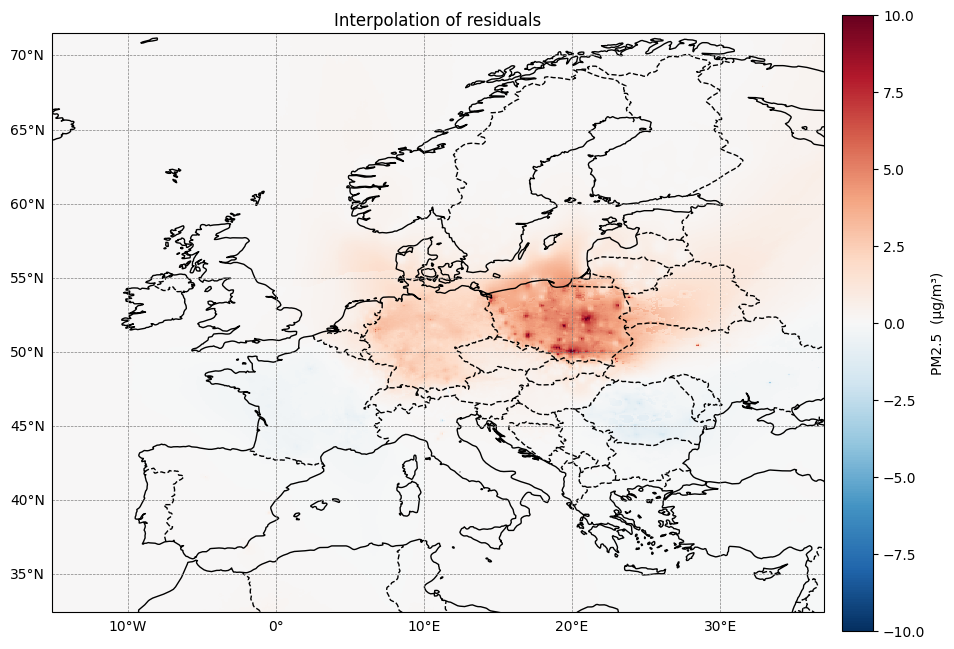

In [89]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Initial and Corrected NetCDF Files ===
initial_netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
corrected_netcdf_path = "HAM/BaseCase_PM25_rh50_Y_IDW_ΗAM.nc"  # Change this if needed

# Open NetCDF datasets
ds_initial = xr.open_dataset(initial_netcdf_path)
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract PM2.5 data (Ensure no time dimension)
initial_pm25 = ds_initial["SURF_ug_PM25_rh50"].squeeze().values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Compute difference (Corrected - Initial) and ensure correct shape
difference = (corrected_pm25 - initial_pm25).squeeze()

# Extract coordinates
lon = ds_initial["lon"].values
lat = ds_initial["lat"].values

# === Define Plot Limits ===
cbar_min = -10
cbar_max = 10

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the difference (Ensure shape consistency)
im = ax.pcolormesh(lon, lat, difference, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("PM2.5  (µg/m³)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Interpolation of residuals")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close datasets
ds_initial.close()
ds_corrected.close()


In [80]:
import os
import netCDF4 as nc
import numpy as np

# === Αρχεία εισόδου και εξόδου ===
original_nc_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
bias_nc_path = "HAM/BaseCase_PM25_rh50_Y_IDW_ΗAM.nc"
corrected_nc_path = "HAM/BaseCase_Corrected_PM25_rh50_Y_HAM.nc"

# Άνοιγμα των NetCDF αρχείων
with nc.Dataset(original_nc_path, "r") as original_nc, nc.Dataset(bias_nc_path, "r") as bias_nc:

    # Φόρτωση των δεδομένων
    lon = original_nc.variables["lon"][:]
    lat = original_nc.variables["lat"][:]
    time = original_nc.variables["time"][:]
    pm25_original = original_nc.variables["SURF_ug_PM25_rh50"][:]
    bias = bias_nc.variables["SURF_ug_PM25_rh50_corrected"][:]

    # Υπολογισμός διορθωμένων τιμών
    pm25_corrected = pm25_original + bias

    # === Δημιουργία νέου NetCDF ===
    if os.path.exists(corrected_nc_path):
        os.remove(corrected_nc_path)

    with nc.Dataset(corrected_nc_path, "w", format="NETCDF4") as new_nc:
        # Δημιουργία διαστάσεων
        new_nc.createDimension("time", None)
        new_nc.createDimension("lat", lat.shape[0])
        new_nc.createDimension("lon", lon.shape[0])

        # Δημιουργία μεταβλητών
        time_var = new_nc.createVariable("time", "f4", ("time",))
        lat_var = new_nc.createVariable("lat", "f4", ("lat",))
        lon_var = new_nc.createVariable("lon", "f4", ("lon",))
        pm25_var = new_nc.createVariable("SURF_ug_PM25_rh50_corrected", "f4", ("time", "lat", "lon"), fill_value=-9999.0)

        # Αντιγραφή attributes από το αρχικό αρχείο
        pm25_var.setncatts(original_nc.variables["SURF_ug_PM25_rh50"].__dict__)

        # Αντιγραφή δεδομένων
        time_var[:] = time
        lat_var[:] = lat
        lon_var[:] = lon
        pm25_var[:] = pm25_corrected

print("Bias correction completed successfully! Corrected NetCDF file saved as", corrected_nc_path)


Bias correction completed successfully! Corrected NetCDF file saved as HAM/BaseCase_Corrected_PM25_rh50_Y_HAM.nc


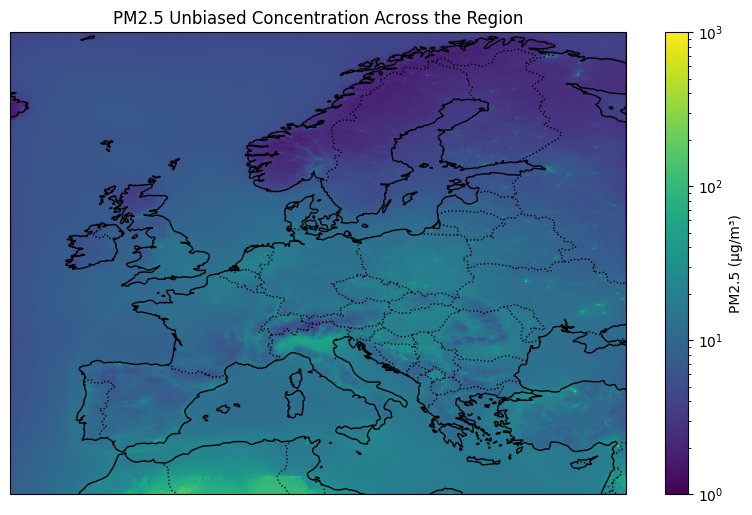

In [81]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

# Open the NetCDF file for PM25
PM25map = netCDF4.Dataset('HAM/BaseCase_Corrected_PM25_rh50_Y_HAM.nc', 'r')  # Replace with the actual file name

# Extract variables: lon, lat, and PM2.5 concentration (first time point)
lon = PM25map.variables['lon'][:]
lat = PM25map.variables['lat'][:]
PM25 = PM25map.variables['SURF_ug_PM25_rh50_corrected'][0, :, :]  # Only the first time point

# Close the dataset
PM25map.close()

# Mask out invalid data (_FillValue)
fill_value = 9.969209968386869e+36  # _FillValue for invalid entries
PM25 = np.ma.masked_equal(PM25, fill_value)


# Define a logarithmic norm
norm = mcolors.LogNorm(vmin=1, vmax=1000)  # Apply logarithmic normalization from 1 to 10000

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the PM2.5 concentration using pcolormesh with logarithmic scaling
mesh = ax.pcolormesh(lon, lat, PM25, cmap='viridis', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# Add a colorbar with the new scale
plt.colorbar(mesh, label='PM2.5 (µg/m³)')

# Add coastlines and borders for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Title and labels
plt.title('PM2.5 Unbiased Concentration Across the Region')

# Show the plot
plt.show()

# IDW - Hybrid Correction (Additive & Rescaled)

In [83]:
import numpy as np
import pandas as pd
import netCDF4 as nc
from scipy.spatial import cKDTree
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import itertools

# === Load Data ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Compute Additive Bias
df["bias_additive"] = df["SURF_ug_PM25_rh50"] - df["nearest_SURF_ug_PM25_rh50"]

# Load NetCDF file
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

# Extract NetCDF grid coordinates
lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_modeled = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]

# Create meshgrid
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
points_grid = np.column_stack([lon_mesh.ravel(), lat_mesh.ravel()])

# Prepare station data points
station_points = df[["nearest_grid_lon", "nearest_grid_lat"]].values
bias_additive_values = df["bias_additive"].values

# Build KDTree for efficient nearest neighbor search
tree = cKDTree(station_points)

# === Hybrid IDW Function (Additive + Rescaled Additive) ===
def idw_hybrid_rescaled(grid_points, station_points, bias_additive, pm25_modeled, p=2, k=5, threshold=15):
    interpolated = np.zeros(grid_points.shape[0])

    for i in tqdm(range(grid_points.shape[0]), desc="Interpolating Hybrid IDW", unit="grid point"):
        dists, idxs = tree.query(grid_points[i], k=k)

        if np.any(dists == 0):  # Exact match case
            interpolated[i] = bias_additive[idxs[dists == 0]][0]
        else:
            weights = 1 / (dists ** p)
            interpolated_additive = np.sum(weights * bias_additive[idxs]) / np.sum(weights)

            # Υπολογισμός συντελεστή κλιμάκωσης (λ) για Rescaled Additive
            station_lons, station_lats = station_points[idxs].T
            grid_indices = np.array([np.argmin(np.abs(lon - lon_val)) for lon_val in station_lons])
            lat_indices = np.array([np.argmin(np.abs(lat - lat_val)) for lat_val in station_lats])
            scaling_factor = np.sum(weights * pm25_modeled[lat_indices, grid_indices]) / np.sum(weights)

            # Hybrid Correction Logic
            if pm25_modeled.ravel()[i] < threshold:
                interpolated[i] = interpolated_additive  # Additive Correction
            else:
                interpolated[i] = scaling_factor * interpolated_additive  # Rescaled Additive Correction

    return interpolated

# === Apply Hybrid Correction (Additive + Rescaled Additive) ===
print("\nInterpolating bias using Hybrid IDW (Additive + Rescaled Additive)...")
interpolated_bias_hybrid = idw_hybrid_rescaled(points_grid, station_points, bias_additive_values, pm25_modeled)

# Reshape the result to match the grid shape
interpolated_bias_hybrid = interpolated_bias_hybrid.reshape(pm25_modeled.shape)

# Apply correction
corrected_pm25_hybrid = pm25_modeled + interpolated_bias_hybrid

# === Save the Corrected NetCDF File ===
corrected_netcdf_path = "corrected_pm25_hybrid_rescaled.nc"

if os.path.exists(corrected_netcdf_path):
    os.remove(corrected_netcdf_path)
    print(f"Deleted existing file: {corrected_netcdf_path}")

new_dataset = nc.Dataset(corrected_netcdf_path, "w", format="NETCDF4")

# Create dimensions
new_dataset.createDimension("lat", lat.shape[0])
new_dataset.createDimension("lon", lon.shape[0])

# Create variables
lat_var = new_dataset.createVariable("lat", "f4", ("lat",))
lon_var = new_dataset.createVariable("lon", "f4", ("lon",))
pm25_var = new_dataset.createVariable("SURF_ug_PM25_rh50_corrected", "f4", ("lat", "lon"))

# Assign metadata BEFORE writing data
pm25_var.setncatts(dataset.variables["SURF_ug_PM25_rh50"].__dict__)
new_dataset.description = "Bias-corrected PM2.5 using Hybrid IDW (Additive + Rescaled Additive)"

# Assign data
lat_var[:] = lat
lon_var[:] = lon
pm25_var[:, :] = corrected_pm25_hybrid

# Close new NetCDF file
new_dataset.close()
dataset.close()

print("Hybrid IDW (Additive + Rescaled Additive) Correction completed successfully! Corrected NetCDF file saved as", corrected_netcdf_path)



Interpolating bias using Hybrid IDW (Additive + Rescaled Additive)...


Interpolating Hybrid IDW: 100%|██████████| 406901/406901 [06:55<00:00, 980.11grid point/s] 

Hybrid IDW (Additive + Rescaled Additive) Correction completed successfully! Corrected NetCDF file saved as corrected_pm25_hybrid_rescaled.nc


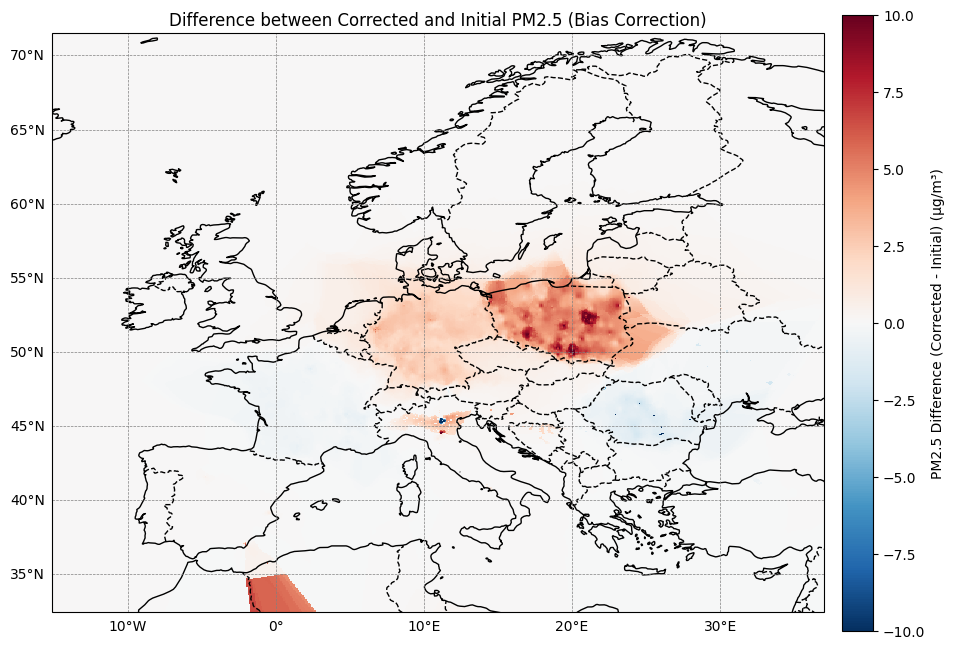

In [90]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Initial and Corrected NetCDF Files ===
initial_netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
corrected_netcdf_path = "corrected_pm25_hybrid_rescaled.nc"

# Open NetCDF datasets
ds_initial = xr.open_dataset(initial_netcdf_path)
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract PM2.5 data (Ensure no time dimension)
initial_pm25 = ds_initial["SURF_ug_PM25_rh50"].squeeze().values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Compute difference (Corrected - Initial) and ensure correct shape
difference = (corrected_pm25 - initial_pm25).squeeze()

# Extract coordinates
lon = ds_initial["lon"].values
lat = ds_initial["lat"].values

# === Define Plot Limits ===
cbar_min = -10
cbar_max = 10

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the difference (Ensure shape consistency)
im = ax.pcolormesh(lon, lat, difference, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("PM2.5 Difference (Corrected - Initial) (µg/m³)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Difference between Corrected and Initial PM2.5 (Bias Correction)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close datasets
ds_initial.close()
ds_corrected.close()


# IDW - Hybrid Correction (Multiplicative & Rescaled)

In [85]:
import numpy as np
import pandas as pd
import netCDF4 as nc
from scipy.spatial import cKDTree
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import itertools

# === Load Data ===
csv_file_path = "basePM25nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Compute Multiplicative Bias Ratio
df["bias_ratio"] = df["SURF_ug_PM25_rh50"] / df["nearest_SURF_ug_PM25_rh50"]
df["bias_ratio"] = df["bias_ratio"].replace([np.inf, -np.inf], np.nan)
df.dropna(subset=["bias_ratio"], inplace=True)

# Compute Additive Bias for Rescaled Additive
df["bias_additive"] = df["SURF_ug_PM25_rh50"] - df["nearest_SURF_ug_PM25_rh50"]

# Load NetCDF file
netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

# Extract NetCDF grid coordinates
lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
pm25_modeled = dataset.variables["SURF_ug_PM25_rh50"][0, :, :]

# Create meshgrid
lon_mesh, lat_mesh = np.meshgrid(lon, lat)
points_grid = np.column_stack([lon_mesh.ravel(), lat_mesh.ravel()])

# Prepare station data points
station_points = df[["nearest_grid_lon", "nearest_grid_lat"]].values
bias_ratio_values = df["bias_ratio"].values
bias_additive_values = df["bias_additive"].values

# Build KDTree for efficient nearest neighbor search
tree = cKDTree(station_points)

# === Grid Search για τα βέλτιστα p και k ===
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Προετοιμασία train-test sets
train_points = train_df[["nearest_grid_lon", "nearest_grid_lat"]].values
train_ratio_values = train_df["bias_ratio"].values
train_additive_values = train_df["bias_additive"].values

test_points = test_df[["nearest_grid_lon", "nearest_grid_lat"]].values
test_ratio_values = test_df["bias_ratio"].values
test_additive_values = test_df["bias_additive"].values

# Κατασκευή KDTree για τα train points
train_tree = cKDTree(train_points)

# Υποψήφιες τιμές για τα hyperparameters
p_values = [1, 2, 3]
k_values = [3, 5, 7, 10]
threshold = 15  # Threshold για Hybrid Correction

best_rmse = float("inf")
best_params = None

# === Grid Search για p, k ===
for p, k in itertools.product(p_values, k_values):
    predicted_ratio = []
    predicted_additive = []

    for test_point in test_points:
        dists, idxs = train_tree.query(test_point, k=k)

        if np.any(dists == 0):  # Exact match case
            predicted_ratio.append(train_ratio_values[idxs[dists == 0]][0])
            predicted_additive.append(train_additive_values[idxs[dists == 0]][0])
        else:
            weights = 1 / (dists ** p)
            interpolated_ratio = np.sum(weights * train_ratio_values[idxs]) / np.sum(weights)
            interpolated_additive = np.sum(weights * train_additive_values[idxs]) / np.sum(weights)

            predicted_ratio.append(interpolated_ratio)
            predicted_additive.append(interpolated_additive)

    # Υπολογισμός RMSE
    rmse_ratio = np.sqrt(mean_squared_error(test_ratio_values, predicted_ratio))
    rmse_additive = np.sqrt(mean_squared_error(test_additive_values, predicted_additive))
    rmse_total = (rmse_ratio + rmse_additive) / 2  # Μέσο RMSE

    if rmse_total < best_rmse:
        best_rmse = rmse_total
        best_params = (p, k)

print(f"\nBest parameters found: p={best_params[0]}, k={best_params[1]} with RMSE={best_rmse:.4f}")

# === Hybrid IDW Function (Multiplicative + Rescaled Additive) ===
def idw_hybrid_rescaled(grid_points, station_points, bias_ratio, bias_additive, pm25_modeled, p, k, threshold):
    interpolated = np.zeros(grid_points.shape[0])

    for i in tqdm(range(grid_points.shape[0]), desc="Interpolating Hybrid IDW", unit="grid point"):
        dists, idxs = tree.query(grid_points[i], k=k)

        if np.any(dists == 0):  # Exact match case
            interpolated[i] = bias_ratio[idxs[dists == 0]][0]
        else:
            weights = 1 / (dists ** p)
            interpolated_ratio = np.sum(weights * bias_ratio[idxs]) / np.sum(weights)
            interpolated_additive = np.sum(weights * bias_additive[idxs]) / np.sum(weights)

            # Υπολογισμός συντελεστή κλιμάκωσης (λ)
            station_lons, station_lats = station_points[idxs].T
            grid_indices = np.array([np.argmin(np.abs(lon - lon_val)) for lon_val in station_lons])
            lat_indices = np.array([np.argmin(np.abs(lat - lat_val)) for lat_val in station_lats])
            scaling_factor = np.sum(weights * pm25_modeled[lat_indices, grid_indices]) / np.sum(weights)

            # Hybrid Correction Logic
            if pm25_modeled.ravel()[i] < threshold:
                interpolated[i] = (interpolated_ratio - 1) * pm25_modeled.ravel()[i]  # Multiplicative Correction
            else:
                interpolated[i] = scaling_factor * interpolated_additive  # Rescaled Additive Correction

    return interpolated

# === Apply Hybrid Correction (Multiplicative + Rescaled Additive) ===
print("\nInterpolating bias using Hybrid IDW (Multiplicative + Rescaled Additive) with optimized parameters...")
interpolated_bias_hybrid = idw_hybrid_rescaled(points_grid, station_points, bias_ratio_values, bias_additive_values, pm25_modeled, best_params[0], best_params[1], threshold)

# Reshape the result to match the grid shape
interpolated_bias_hybrid = interpolated_bias_hybrid.reshape(pm25_modeled.shape)

# Apply correction
corrected_pm25_hybrid = pm25_modeled + interpolated_bias_hybrid

print("Hybrid IDW (Multiplicative + Rescaled Additive) Correction completed successfully!")



Best parameters found: p=2, k=10 with RMSE=0.2750

Interpolating bias using Hybrid IDW (Multiplicative + Rescaled Additive) with optimized parameters...


Interpolating Hybrid IDW: 100%|██████████| 406901/406901 [12:48<00:00, 529.49grid point/s]

Hybrid IDW (Multiplicative + Rescaled Additive) Correction completed successfully!


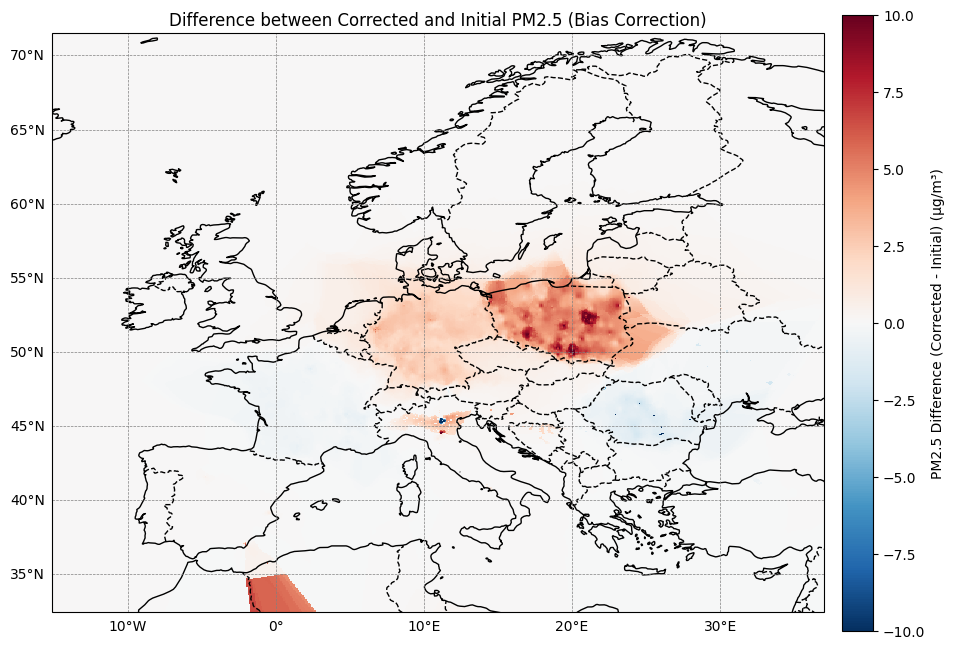

In [91]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Initial and Corrected NetCDF Files ===
initial_netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
corrected_netcdf_path = "corrected_pm25_hybrid_rescaled.nc"

# Open NetCDF datasets
ds_initial = xr.open_dataset(initial_netcdf_path)
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract PM2.5 data (Ensure no time dimension)
initial_pm25 = ds_initial["SURF_ug_PM25_rh50"].squeeze().values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Compute difference (Corrected - Initial) and ensure correct shape
difference = (corrected_pm25 - initial_pm25).squeeze()

# Extract coordinates
lon = ds_initial["lon"].values
lat = ds_initial["lat"].values

# === Define Plot Limits ===
cbar_min = -10
cbar_max = 10

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the difference (Ensure shape consistency)
im = ax.pcolormesh(lon, lat, difference, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("PM2.5 Difference (Corrected - Initial) (µg/m³)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Difference between Corrected and Initial PM2.5 (Bias Correction)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close datasets
ds_initial.close()
ds_corrected.close()
